In [2]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

2023-12-10 03:15:04.115301: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 03:15:04.117322: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 03:15:04.164129: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 03:15:04.165153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 03:15:04.814846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
def extract_features(file_path):
    try:
        audio_data, _ = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio_data, sr=22050, n_mfcc=13)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

In [4]:
def load_data(folder_path):
    data = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.mp3'):
            file_path = os.path.join(folder_path, filename)
            
            language = filename.split('_')[2]
            
            features = extract_features(file_path)
            if features is not None:
                data.append(features)
                labels.append(language)
    
    return np.array(data), np.array(labels)

In [5]:
audio_folder = '/home/basil3325/languages'

In [5]:
X, y = load_data(audio_folder)

In [6]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [1]:
svm_classifier = SVC(probability=True)
svm_classifier.fit(X_train, y_train)

gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train, y_train)

voting_classifier = VotingClassifier(estimators=[
    ('svm', svm_classifier),
    ('gb', gb_classifier)
], voting='soft') 

voting_classifier.fit(X_train, y_train)

NameError: name 'models' is not defined

In [15]:
y_pred = voting_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 29.83%


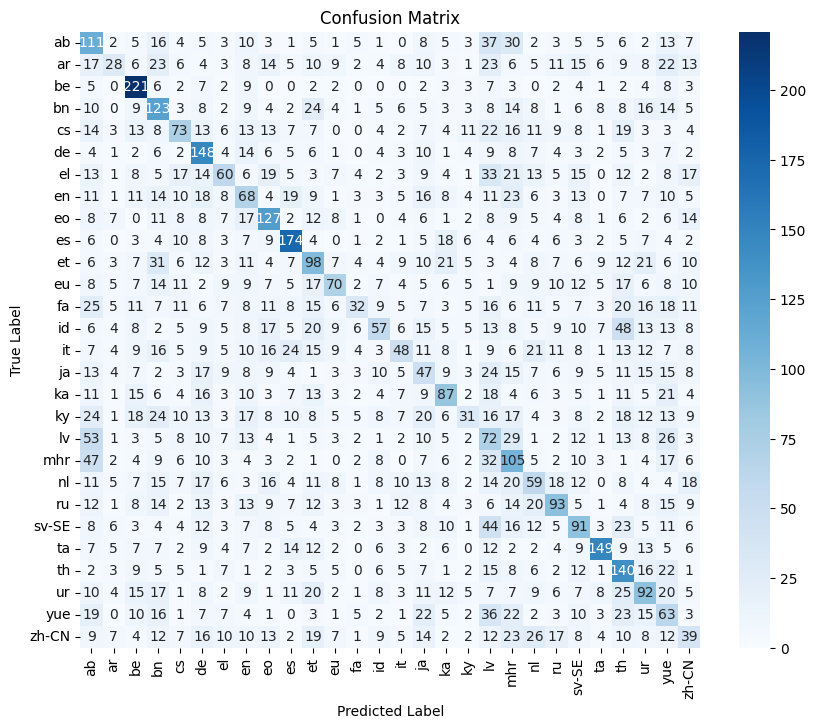

In [10]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [11]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
               precision    recall  f1-score   support

          ab       0.23      0.37      0.29       298
          ar       0.27      0.10      0.15       279
          be       0.51      0.74      0.61       298
          bn       0.29      0.40      0.34       309
          cs       0.31      0.25      0.28       294
          de       0.35      0.55      0.43       271
          el       0.31      0.20      0.24       307
          en       0.22      0.23      0.22       298
          eo       0.38      0.43      0.41       292
          es       0.51      0.57      0.54       304
          et       0.27      0.29      0.28       334
          eu       0.39      0.25      0.31       280
          fa       0.35      0.11      0.17       294
          id       0.32      0.17      0.23       326
          it       0.29      0.16      0.21       300
          ja       0.15      0.17      0.16       272
          ka       0.34      0.31      0.33       281
   

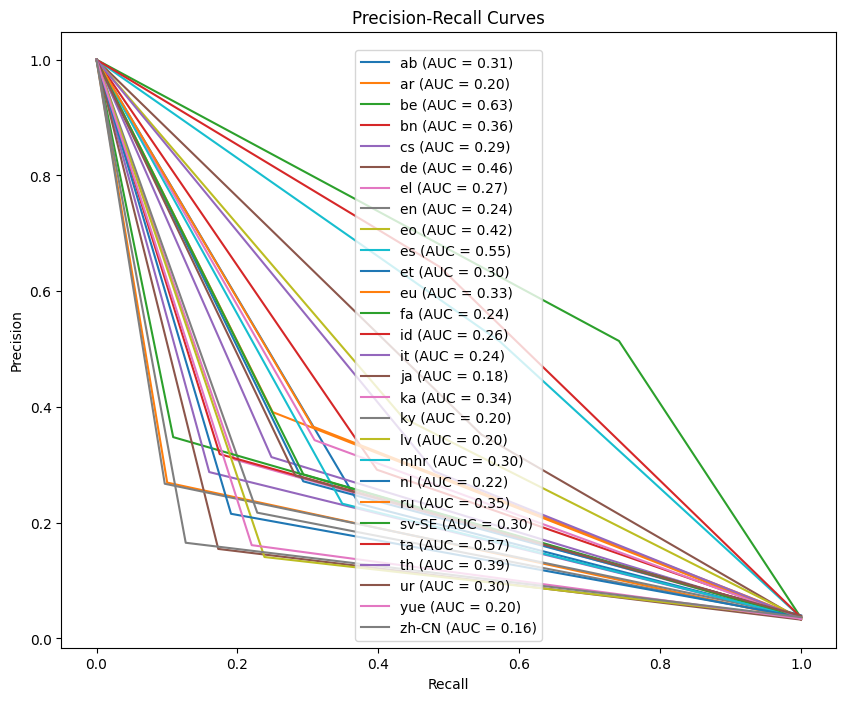

In [12]:
plt.figure(figsize=(10, 8))
for i, label in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test == label_encoder.transform([label]), y_pred == label_encoder.transform([label]))
    area = auc(recall, precision)
    plt.plot(recall, precision, label=f'{label} (AUC = {area:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

/tmp/ipykernel_3638/2736260141.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_encoder.classes_, y=class_accuracy, palette='viridis')


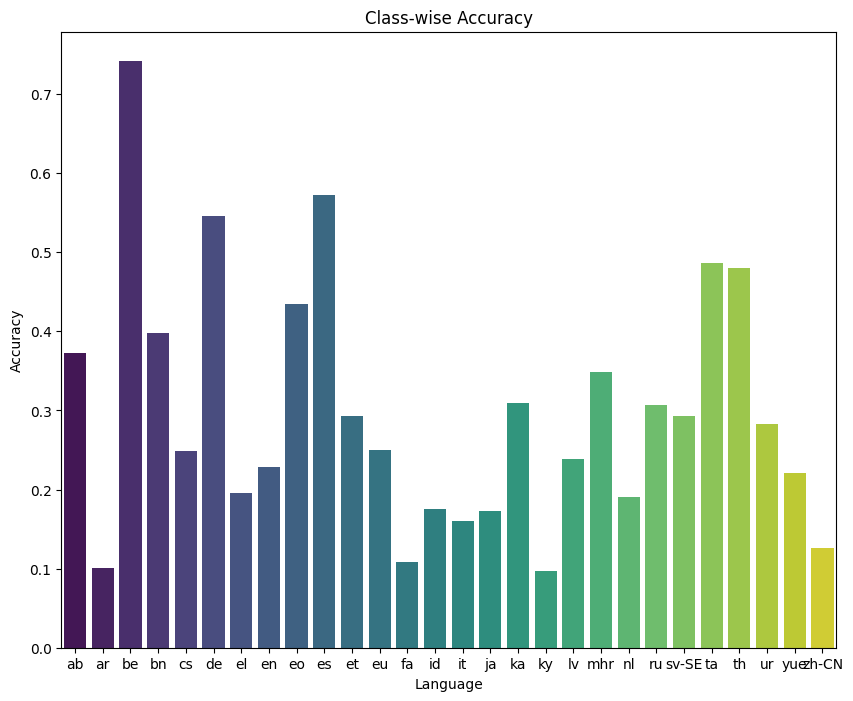

In [13]:
class_accuracy = [accuracy_score(y_test[y_test == label_encoder.transform([label])], y_pred[y_test == label_encoder.transform([label])]) for label in label_encoder.classes_]

plt.figure(figsize=(10, 8))
sns.barplot(x=label_encoder.classes_, y=class_accuracy, palette='viridis')
plt.xlabel('Language')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.show()
